<a href="https://colab.research.google.com/drive/1pYoxN_4ISQW10Cem1oWfDT0uOdtRUEPy#scrollTo=PFsOHChebLVP" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pnemonia Detection**

### Import libraries

In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
from PIL import Image

### Downlaod dataset directly from **kaggle** to **colab** and creating the following structure

```
Example of file structure

images
└───train <- training images
│   └───have
│   │   │   ---.jpeg
│   │   │   ---.jpeg
│   │   │   ...      
│   └───have_not
│       │   ---.jpeg
│       │   ---.jpeg
│       │   ...
│   
└───val <- testing images
│   └───have
│   │   │   ---.jpeg
│   │   │   ---.jpeg
│   │   │   ...      
│   └───have_not
│       │   ---.jpeg
│       │   ---.jpeg
│       │   ... 

```

In [ ]:
!chmod 600 /content/kaggle.json #how to keep our api key unavailabe to others

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle # update kaggle api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
# Get data directly from kaggle 
import os 

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle competitions download -c rsna-pneumonia-detection-challenge

rsna-pneumonia-detection-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


**Unzip the dataset**

In [ ]:
import zipfile

data = zipfile.ZipFile("rsna-pneumonia-detection-challenge.zip")
data.extractall()
data.close()

### Data loading

In [ ]:
df = pd.read_csv("stage_2_train_labels.csv")

In [ ]:
df.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [ ]:
df.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


**Checking the null values**

In [ ]:
df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

**Checking balance of the target**

In [ ]:
df.Target.value_counts(normalize=True)

0    0.683892
1    0.316108
Name: Target, dtype: float64

In [ ]:
# removing diplicate patient
df = df.drop_duplicates("patientId")

In [ ]:
ROOT_PATH = Path("stage_2_train_images/")

In [ ]:
df.patientId.iloc[0]

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

**Displaying dicom images**

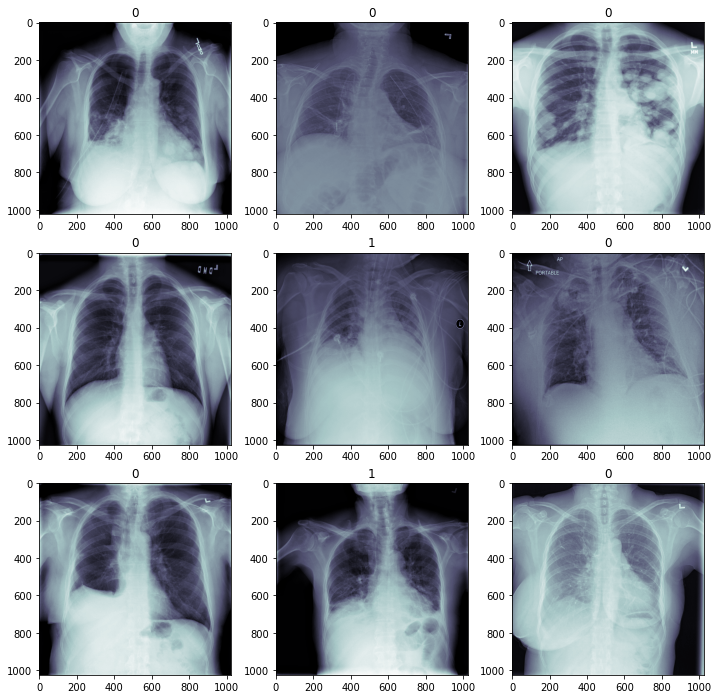

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(12, 12))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = df.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id # Create the path to the dcm file
        dcm_path = dcm_path.with_suffix(".dcm") # adding .dcm suffix
        dcm = pydicom.read_file(dcm_path).pixel_array # read the dicom file
        
        label = df["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

### Converting **dicom** to **jpeg**

In [ ]:
df.Target.value_counts()

0    20672
1     6012
Name: Target, dtype: int64

In [ ]:
train = os.listdir("/content/stage_2_train_images")

In [ ]:
os.mkdir("./images")
os.mkdir("./images/train")
os.mkdir("./images/val")
os.mkdir("./images/train/have")
os.mkdir("./images/train/have_not")
os.mkdir("./images/val/have")
os.mkdir("./images/val/have_not")

for c,i in enumerate(tqdm(train)):
  ds = pydicom.dcmread(r"stage_2_train_images/" + i)
  name = i.split(".")[0]
  img = Image.fromarray(ds.pixel_array)
  tar = df[df.patientId == name].values[0][5]
  if tar == 0:
    train_or_val = "train" if c < 24000 else "val"
    img.save("./images/"+ train_or_val + "/have/" + name + ".jpeg")
  else:
    train_or_val = "train" if c < 24000 else "val"
    img.save("./images/"+ train_or_val + "/have_not/" + name + ".jpeg")

  0%|          | 0/26684 [00:00<?, ?it/s]

In [ ]:
for dirpath, dirnames, filenames in os.walk("images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'images'.
There are 2 directories and 0 images in 'images/train'.
There are 0 directories and 5421 images in 'images/train/have_not'.
There are 0 directories and 18579 images in 'images/train/have'.
There are 2 directories and 0 images in 'images/val'.
There are 0 directories and 591 images in 'images/val/have_not'.
There are 0 directories and 2093 images in 'images/val/have'.


In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  # img = cv2.imread(target_folder + "/" + random_image[0])
  img = mpimg.imread(target_folder + "/" + random_image[0])
  
  plt.figure(figsize=(14,10))
  plt.imshow(img, cmap="bone")
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (1024, 1024)


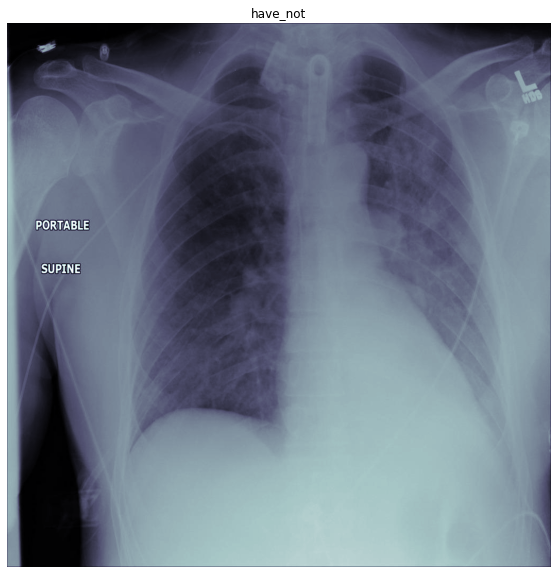

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="images/train/",
                        target_class="have_not")

**using tf.data.dataset api**

In [ ]:
train_dir = "images/train/"
test_dir = "images/val/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 24000 files belonging to 2 classes.
Found 2684 files belonging to 2 classes.


## Train the model

In [ ]:
from tensorflow.keras import layers

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(2, activation="sigmoid", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compile
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history = model.fit(train_data,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)))

Epoch 1/5
750/750 [==============================] - 95s 120ms/step - loss: 0.4159 - accuracy: 0.8055 - val_loss: 0.1644 - val_accuracy: 0.9583
Epoch 2/5
750/750 [==============================] - 75s 99ms/step - loss: 0.3961 - accuracy: 0.8166 - val_loss: 0.1937 - val_accuracy: 0.9453
Epoch 3/5
750/750 [==============================] - 84s 112ms/step - loss: 0.3899 - accuracy: 0.8175 - val_loss: 0.1732 - val_accuracy: 0.9557
Epoch 4/5
750/750 [==============================] - 74s 98ms/step - loss: 0.3854 - accuracy: 0.8223 - val_loss: 0.1529 - val_accuracy: 0.9661
Epoch 5/5
750/750 [==============================] - 75s 100ms/step - loss: 0.3826 - accuracy: 0.8242 - val_loss: 0.1590 - val_accuracy: 0.9661


In [ ]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

In [ ]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

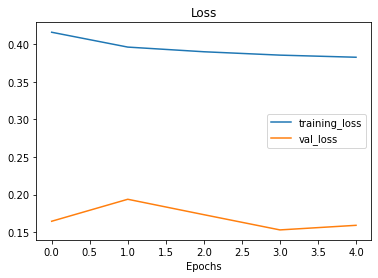

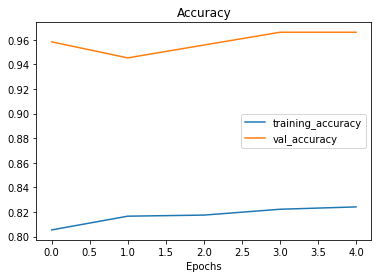

In [ ]:
plot_loss_curves(history)